# Task 2 : MULTICLASS PRODUCT CLASSIFICATION

# Install Packages

NLTK package to dowload the stop words, import PorterStemmer.

In [ ]:
!pip install nltk

Tensor flow to downlad the Universel sentence encoder for embedding the text.

In [ ]:
!pip install tensorflow_text 

# Import Libraries

In [ ]:
import pandas as pd
import re
import string 
import numpy as np

# pre-processing the input features
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

#convert the string text to vector representation
import tensorflow_hub as hub
import tensorflow_text
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# To create traning and test dataset
from sklearn.model_selection import train_test_split

# Loading the model
from sklearn.ensemble import RandomForestClassifier

# Evaluate the model accuaracy
from sklearn.metrics import accuracy_score, classification_report

# Ploting the data analyisis
import matplotlib.pyplot as plt

# Loading Data sets

Reading the Product catalog and train data datasets

In [4]:
product_catalog_pd = pd.read_csv('/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/product_catalogue-v0.1.csv')
train_pd = pd.read_csv('/content/drive/MyDrive/Amazon Shopping Queries Dataset/ Task 2: Multiclass Product Classification/train-v0.1.csv')

In [5]:
product_catalog_pd["product_locale"].unique()

array(['es', 'us', 'jp'], dtype=object)

Select 'US' Locale from both train and product catalog dataset

In [6]:
us_product_catalog_pd = product_catalog_pd.loc[product_catalog_pd['product_locale'] == 'us']
us_train_pd = train_pd.loc[train_pd['query_locale'] == 'us']

# Data Description

**Product Catalog dataset**

In [87]:
us_product_catalog_pd.head(3)

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
167236,B003O0MNGC,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,NaN,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us
167237,B00MARNO5Y,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,NaN,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us
167238,B011RX6PNO,Aero Pure AP120H-SL W Slim Fit 120 CFM Bathroo...,NaN,"Slim Fit Housing Fits Into 2"" X 6"" Ceiling Joi...",Aero Pure,White Finish,us


**Train dataset**

In [8]:
us_train_pd.head(5)

,example_id,query,product_id,query_locale,esci_label
249721,249721,revent 80 cfm,B000MOO21W,us,irrelevant
249722,249722,revent 80 cfm,B001E6DMKY,us,exact
249723,249723,revent 80 cfm,B003O0MNGC,us,exact
249724,249724,revent 80 cfm,B00MARNO5Y,us,exact
249725,249725,revent 80 cfm,B00XBZFWWM,us,exact


**Product catalog and Train dataset info**

In [9]:
print("Product catalog: \n")
us_product_catalog_pd.info()
print("\n \n")
print("Train: \n")
us_train_pd.info()

Product catalog: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216070 entries, 167236 to 1753643
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   product_id            1216070 non-null  object
 1   product_title         1215854 non-null  object
 2   product_description   646076 non-null   object
 3   product_bullet_point  1037091 non-null  object
 4   product_brand         1143575 non-null  object
 5   product_color_name    809776 non-null   object
 6   product_locale        1216070 non-null  object
dtypes: object(7)
memory usage: 74.2+ MB

 

Train: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1272626 entries, 249721 to 1522346
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   example_id    1272626 non-null  int64 
 1   query         1272626 non-null  object
 2   product_id    1272626 non-null  object
 3   

**Product catalog describe**

In [10]:
us_product_catalog_pd.describe(include='object')

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale
count,1216070,1215854,646076,1037091,1143575,809776,1216070
unique,1216070,1193661,541651,861808,211177,175308,1
top,B003O0MNGC,Episode 1,This pre-owned or refurbished product has been...,Used Book in Good Condition,Nike,Black,us
freq,1,152,1192,2718,6160,125444,1216070


**Train dataset describe**

In [11]:
us_train_pd.describe(include='object')

,query,product_id,query_locale,esci_label
count,1272626,1272626,1272626,1272626
unique,68139,913438,1,4
top,tv,B01HFFXLNA,us,exact
freq,198,88,1272626,874058


# Design of features

**Join the product catalog and train dataset based on product id**

In [12]:
us_train_product_df = us_train_pd.merge(us_product_catalog_pd,left_on = ['product_id'],right_on=['product_id'], how= 'left')

In [86]:
us_train_product_df.head(3)

,example_id,query,product_id,query_locale,esci_label,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale,product_text,query_product_text
0,249721,revent 80 cfm,B000MOO21W,us,irrelevant,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,,WhisperCeiling fans feature a totally enclosed...,Panasonic,White,us,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,revent 80 cfm Panasonic FV-20VQ3 WhisperCeili...
1,249722,revent 80 cfm,B001E6DMKY,us,exact,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",,"HIGH-QUALITY FAN: Very quiet, energy efficient...",Broan-NuTone,White,us,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",revent 80 cfm Broan Very Quiet Ceiling Bathro...
2,249723,revent 80 cfm,B003O0MNGC,us,exact,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,revent 80 cfm Delta BreezSignature VFB25ACH 8...


**Combine Product Catalog Text into one column**

In [14]:
columns = ['product_title', 'product_bullet_point', 'product_brand', 'product_color_name']
us_train_product_df['product_text'] = us_train_product_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [22]:
us_train_product_df.head(5)

,example_id,query,product_id,query_locale,esci_label,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale,product_text,query_product_text
0,249721,revent 80 cfm,B000MOO21W,us,irrelevant,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,,WhisperCeiling fans feature a totally enclosed...,Panasonic,White,us,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,revent 80 cfm Panasonic FV-20VQ3 WhisperCeili...
1,249722,revent 80 cfm,B001E6DMKY,us,exact,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",,"HIGH-QUALITY FAN: Very quiet, energy efficient...",Broan-NuTone,White,us,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",revent 80 cfm Broan Very Quiet Ceiling Bathro...
2,249723,revent 80 cfm,B003O0MNGC,us,exact,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,revent 80 cfm Delta BreezSignature VFB25ACH 8...
3,249724,revent 80 cfm,B00MARNO5Y,us,exact,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,revent 80 cfm Aero Pure AP80RVLW Super Quiet ...
4,249725,revent 80 cfm,B00XBZFWWM,us,exact,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,,Retrofit Solution: Ideal for residential remod...,Panasonic,White,us,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,revent 80 cfm Panasonic FV-0811VF5 WhisperFit...


**Combine Query and product Text Columns**



In [18]:
columns = ['query','product_text']
us_train_product_df['query_product_text'] = us_train_product_df[columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [41]:
us_train_product_df.head(5)

,example_id,query,product_id,query_locale,esci_label,product_title,product_description,product_bullet_point,product_brand,product_color_name,product_locale,product_text,query_product_text
0,249721,revent 80 cfm,B000MOO21W,us,irrelevant,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,,WhisperCeiling fans feature a totally enclosed...,Panasonic,White,us,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,revent 80 cfm Panasonic FV-20VQ3 WhisperCeili...
1,249722,revent 80 cfm,B001E6DMKY,us,exact,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",,"HIGH-QUALITY FAN: Very quiet, energy efficient...",Broan-NuTone,White,us,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",revent 80 cfm Broan Very Quiet Ceiling Bathro...
2,249723,revent 80 cfm,B003O0MNGC,us,exact,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,,Virtually silent at less than 0.3 sones\nPreci...,DELTA ELECTRONICS (AMERICAS) LTD.,White,us,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,revent 80 cfm Delta BreezSignature VFB25ACH 8...
3,249724,revent 80 cfm,B00MARNO5Y,us,exact,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,,Super quiet 80CFM energy efficient fan virtual...,Aero Pure,White,us,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,revent 80 cfm Aero Pure AP80RVLW Super Quiet ...
4,249725,revent 80 cfm,B00XBZFWWM,us,exact,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,,Retrofit Solution: Ideal for residential remod...,Panasonic,White,us,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,revent 80 cfm Panasonic FV-0811VF5 WhisperFit...


In [40]:
us_train_product_modified_df = us_train_product_df[['example_id', 'query', 'product_id','esci_label', 'product_text','query_product_text']].copy()

In [44]:
us_train_product_modified_df.head(5)

,example_id,query,product_id,esci_label,product_text,query_product_text
0,249721,revent 80 cfm,B000MOO21W,irrelevant,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,revent 80 cfm Panasonic FV-20VQ3 WhisperCeili...
1,249722,revent 80 cfm,B001E6DMKY,exact,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",revent 80 cfm Broan Very Quiet Ceiling Bathro...
2,249723,revent 80 cfm,B003O0MNGC,exact,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,revent 80 cfm Delta BreezSignature VFB25ACH 8...
3,249724,revent 80 cfm,B00MARNO5Y,exact,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,revent 80 cfm Aero Pure AP80RVLW Super Quiet ...
4,249725,revent 80 cfm,B00XBZFWWM,exact,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,revent 80 cfm Panasonic FV-0811VF5 WhisperFit...


In [45]:
from sklearn.utils import shuffle

us_train_product_modified_df = shuffle(us_train_product_modified_df)

us_train_product_modified_sampe_df = us_train_product_modified_df.sample(n = 33333)

In [46]:
us_train_product_modified_sampe_df.head(5)

,example_id,query,product_id,esci_label,product_text,query_product_text
339928,589649,elite socks,B07TBT7CBK,exact,Basketball Socks Men's Outdoor Athletic Crew S...,elite socks Basketball Socks Men's Outdoor Ath...
583677,833398,litter box dome,B000256ESU,complement,"Petmate Cleanstep Litter Box Liners, Jumbo, 8 ...",litter box dome Petmate Cleanstep Litter Box L...
108018,357739,backpacks for highschool,B07PF7M6R8,exact,"MATEIN High School Backpack, College Middle Hi...",backpacks for highschool MATEIN High School Ba...
808638,1058359,rhinestone tower crowns,B07D987GJS,exact,FUMUD Silver Color Baroque Vintage Eiffel Towe...,rhinestone tower crowns FUMUD Silver Color Bar...
1141614,1391335,10 frame medium hive box without frames,B0933NYCDZ,exact,Top Chimney Feeder for Langstroth Wooden Beehi...,10 frame medium hive box without frames Top Ch...


# Data Cleaning

**Check Null Values**

In [47]:
us_train_product_modified_sampe_df.isnull().sum()

example_id            0
query                 0
product_id            0
esci_label            0
product_text          0
query_product_text    0
dtype: int64

**Apply Preprocessing**

In [48]:
stop_words = stopwords.words('english')
Stemmer = PorterStemmer()
table = str.maketrans('', '', string.punctuation)

def data_cleaning(text):
  texts = re.sub("[^a-zA-Z]", " ", text)
  texts = [texts.lower() for texts in text.split() if texts.lower() not in stop_words]
  texts = [Stemmer.stem(t) for t in texts]
  texts = [t.translate(table) for t in texts]
  return " ".join(texts)

us_train_product_modified_sampe_df['query'] = us_train_product_modified_sampe_df['query'].apply(data_cleaning)
us_train_product_modified_sampe_df['product_text'] = us_train_product_modified_sampe_df['product_text'].apply(data_cleaning)
us_train_product_modified_sampe_df['query_product_text'] = us_train_product_modified_sampe_df['query_product_text'].apply(data_cleaning)

In [49]:
us_train_product_modified_sampe_df.head(5)

,example_id,query,product_id,esci_label,product_text,query_product_text
339928,589649,elit sock,B07TBT7CBK,exact,basketbal sock men outdoor athlet crew sock cu...,elit sock basketbal sock men outdoor athlet cr...
583677,833398,litter box dome,B000256ESU,complement,petmat cleanstep litter box liners jumbo 8 cou...,litter box dome petmat cleanstep litter box li...
108018,357739,backpack highschool,B07PF7M6R8,exact,matein high school backpack colleg middl high ...,backpack highschool matein high school backpac...
808638,1058359,rhineston tower crown,B07D987GJS,exact,fumud silver color baroqu vintag eiffel tower ...,rhineston tower crown fumud silver color baroq...
1141614,1391335,10 frame medium hive box without frame,B0933NYCDZ,exact,top chimney feeder langstroth wooden beehiv ap...,10 frame medium hive box without frame top chi...


In [50]:
us_train_product_modified_sampe_df.isnull().sum()

example_id            0
query                 0
product_id            0
esci_label            0
product_text          0
query_product_text    0
dtype: int64

# Data visualization

**visualization of target variables**

In [51]:
us_train_product_modified_sampe_df.esci_label.value_counts()

exact         22938
substitute     6707
irrelevant     2982
complement      706
Name: esci_label, dtype: int64

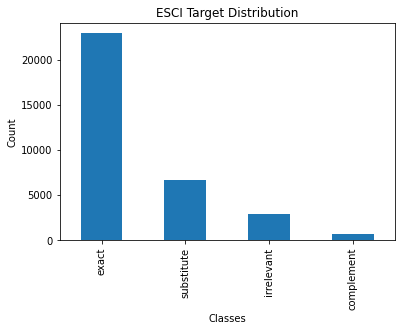

In [52]:
us_train_product_modified_sampe_df.esci_label.value_counts().plot(kind='bar', title='ESCI Target Distribution', xlabel= 'Classes', ylabel = 'Count')
plt.show()

**visualization of target with query and product text**

In [53]:
us_train_product_modified_sampe_df['length_query_product_text'] = us_train_product_modified_sampe_df['query_product_text'].apply(len)

In [66]:
us_train_product_modified_sampe_df.head(5)

,example_id,query,product_id,esci_label,product_text,query_product_text,length_query_product_text
339928,589649,elit sock,B07TBT7CBK,exact,basketbal sock men outdoor athlet crew sock cu...,elit sock basketbal sock men outdoor athlet cr...,933
583677,833398,litter box dome,B000256ESU,complement,petmat cleanstep litter box liners jumbo 8 cou...,litter box dome petmat cleanstep litter box li...,152
108018,357739,backpack highschool,B07PF7M6R8,exact,matein high school backpack colleg middl high ...,backpack highschool matein high school backpac...,1419
808638,1058359,rhineston tower crown,B07D987GJS,exact,fumud silver color baroqu vintag eiffel tower ...,rhineston tower crown fumud silver color baroq...,473
1141614,1391335,10 frame medium hive box without frame,B0933NYCDZ,exact,top chimney feeder langstroth wooden beehiv ap...,10 frame medium hive box without frame top chi...,481


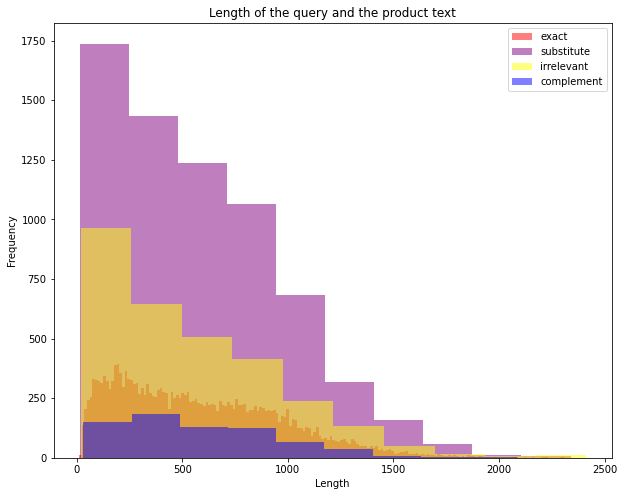

In [88]:
plt.figure(figsize=(10, 8))
us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.esci_label == 'exact'].length_query_product_text.plot(bins=182, kind='hist', color='red', label='exact', alpha=0.5)
us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.esci_label == 'substitute'].length_query_product_text.plot(kind='hist', color='purple', label='substitute', alpha=0.5)
us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.esci_label == 'irrelevant'].length_query_product_text.plot(kind='hist', color='yellow', label='irrelevant', alpha=0.5)
us_train_product_modified_sampe_df[us_train_product_modified_sampe_df.esci_label == 'complement'].length_query_product_text.plot(kind='hist', color='blue', label='complement', alpha=0.5)
plt.legend()
plt.xlabel("Length")
plt.title("Length of the query and the product text");

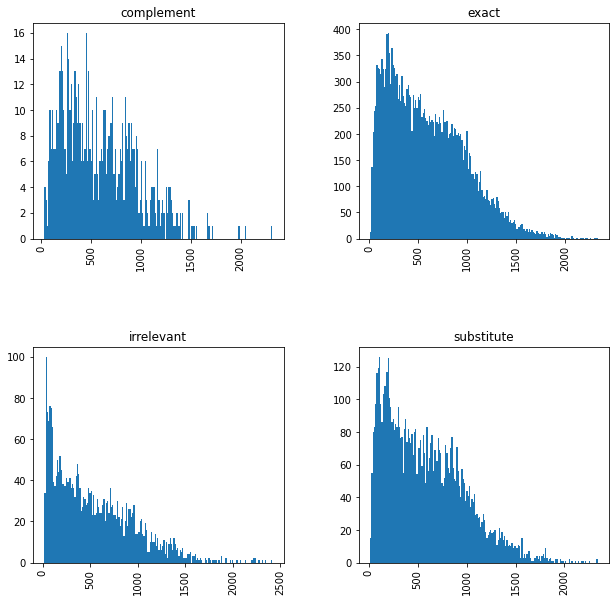

In [89]:
us_train_product_modified_sampe_df.hist(column='length_query_product_text', by='esci_label', bins=182,figsize=(10,10));

# Text Representation

**Tf-idf**

Vectorizating features

In [57]:
MAX_FEAT_DESCP = 5000
trans = ColumnTransformer( [ ('query_trans',TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words='english', ngram_range=(1,3)),'query'),('product_text_trans',TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words='english', ngram_range=(1,3)),'product_text') ],remainder='drop')

us_train_product_modified_sampe_tranformed_df = trans.fit_transform(us_train_product_modified_sampe_df)

Split training and test data

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(us_train_product_modified_sampe_tranformed_df, us_train_product_modified_sampe_df['esci_label'], train_size=0.8, random_state=43)

Target label encoding

In [59]:
from sklearn import preprocessing
tgt_enc = preprocessing.LabelEncoder()

# Train
# fit your targets of the training data to the LabelEncoder instance
tgt_enc.fit(y_train)

# encode the targets as numerical labels
y_train = tgt_enc.transform(y_train)

#Test
# fit your targets of the training data to the LabelEncoder instance
tgt_enc_test = preprocessing.LabelEncoder()

tgt_enc_test.fit(y_test)

# encode the targets as numerical labels
y_test = tgt_enc_test.transform(y_test)

Model Training

In [60]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [61]:
y_pred = random_forest.predict(X_test)

Model Evaluation

In [64]:
from sklearn.metrics import accuracy_score as acc

accuracy_td_idf = acc(y_test, y_pred)
print("Micro F1 Score Accuracy for TF-IDF trained on random forest model: ", accuracy_td_idf)

Micro F1 Score Accuracy for TF-IDF trained on random forest model:  0.6809659517024149


**Universal Sentence Encoder**

Loading the model

In [72]:
use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

Split training and test data

In [73]:
#
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(us_train_product_modified_sampe_df.query_product_text, us_train_product_modified_sampe_df['esci_label'], train_size=0.8, random_state=43)

In [74]:
# split the training data into 500 batches of array split
l_train = [use_encoder(i) for i in np.array_split(X_train, 500)]
X_train_embedding = tf.concat(l_train, axis=0)
del l_train

# split the testing data into 500 batches of array split
l_test = [use_encoder(i) for i in np.array_split(X_test, 500)]
X_test_embedding = tf.concat(l_test, axis=0)
del l_test

Target label encoding

In [ ]:
from sklearn import preprocessing
tgt_enc = preprocessing.LabelEncoder()

# Train
# fit your targets of the training data to the LabelEncoder instance
tgt_enc.fit(y_train)

# encode the targets as numerical labels
y_train = tgt_enc.transform(y_train)

#Test
# fit your targets of the training data to the LabelEncoder instance
tgt_enc_test = preprocessing.LabelEncoder()

tgt_enc_test.fit(y_test)

# encode the targets as numerical labels
y_test = tgt_enc_test.transform(y_test)

Model training

In [75]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train_embedding, y_train)

RandomForestClassifier()

In [76]:
y_pred_embedded = random_forest.predict(X_test_embedding)

Model Evaluation

In [77]:
from sklearn.metrics import accuracy_score as acc

acc_use = acc(y_test, y_pred_embedded)
print("Micro F1 Score Accuracy for Universal Sentence encoding trained on random forest: ", accuracy_td_idf)

Micro F1 Score Accuracy for Universal Sentence encoding trained on random forest:  0.6809659517024149
